In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import  precision_score, recall_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics._regression import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.inspection import permutation_importance

## Part Zero: Data set up and Exploration

In [2]:
AME_train = pd.read_csv(r"C:\Users\ldcal\OneDrive\Desktop\Cal Poly Courses\Fall\GSB-S544\Coding Work\Pyython_Work\Kaggle_Comp\Kaggle_Regression\train_new.csv")
AME_test = pd.read_csv(r"C:\Users\ldcal\OneDrive\Desktop\Cal Poly Courses\Fall\GSB-S544\Coding Work\Pyython_Work\Kaggle_Comp\Kaggle_Regression\test_new.csv")

In [3]:
# Looking at the string variables to see how many unique values they have

for x in ["Street", "Neighborhood", "Bldg Type", "House Style",
            "Roof Style", "Heating", "Electrical", "Functional", "Sale Type"]:

    print(AME_train[x].unique())

['Pave' 'Grvl']
['SawyerW' 'Timber' 'NridgHt' 'Gilbert' 'NAmes' 'Mitchel' 'NWAmes'
 'MeadowV' 'CollgCr' 'OldTown' 'BrkSide' 'Sawyer' 'StoneBr' 'NoRidge'
 'Edwards' 'ClearCr' 'Somerst' 'IDOTRR' 'Crawfor' 'SWISU' 'Blmngtn'
 'Veenker' 'NPkVill' 'Landmrk' 'BrDale' 'Greens' 'Blueste' 'GrnHill']
['1Fam' 'TwnhsE' 'Twnhs' '2fmCon' 'Duplex']
['1Story' 'SLvl' '2Story' 'SFoyer' '1.5Fin' '1.5Unf' '2.5Unf' '2.5Fin']
['Gable' 'Hip' 'Flat' 'Gambrel' 'Mansard' 'Shed']
['GasA' 'GasW' 'Wall' 'Grav' 'OthW' 'Floor']
['SBrkr' 'FuseA' 'FuseP' 'FuseF' 'Mix' nan]
['Typ' 'Min2' 'Min1' 'Maj2' 'Mod' 'Maj1' 'Sal' 'Sev']
['WD' 'COD' 'New' 'ConLD' 'ConLw' 'Oth' 'CWD' 'Con' 'ConLI' 'VWD']


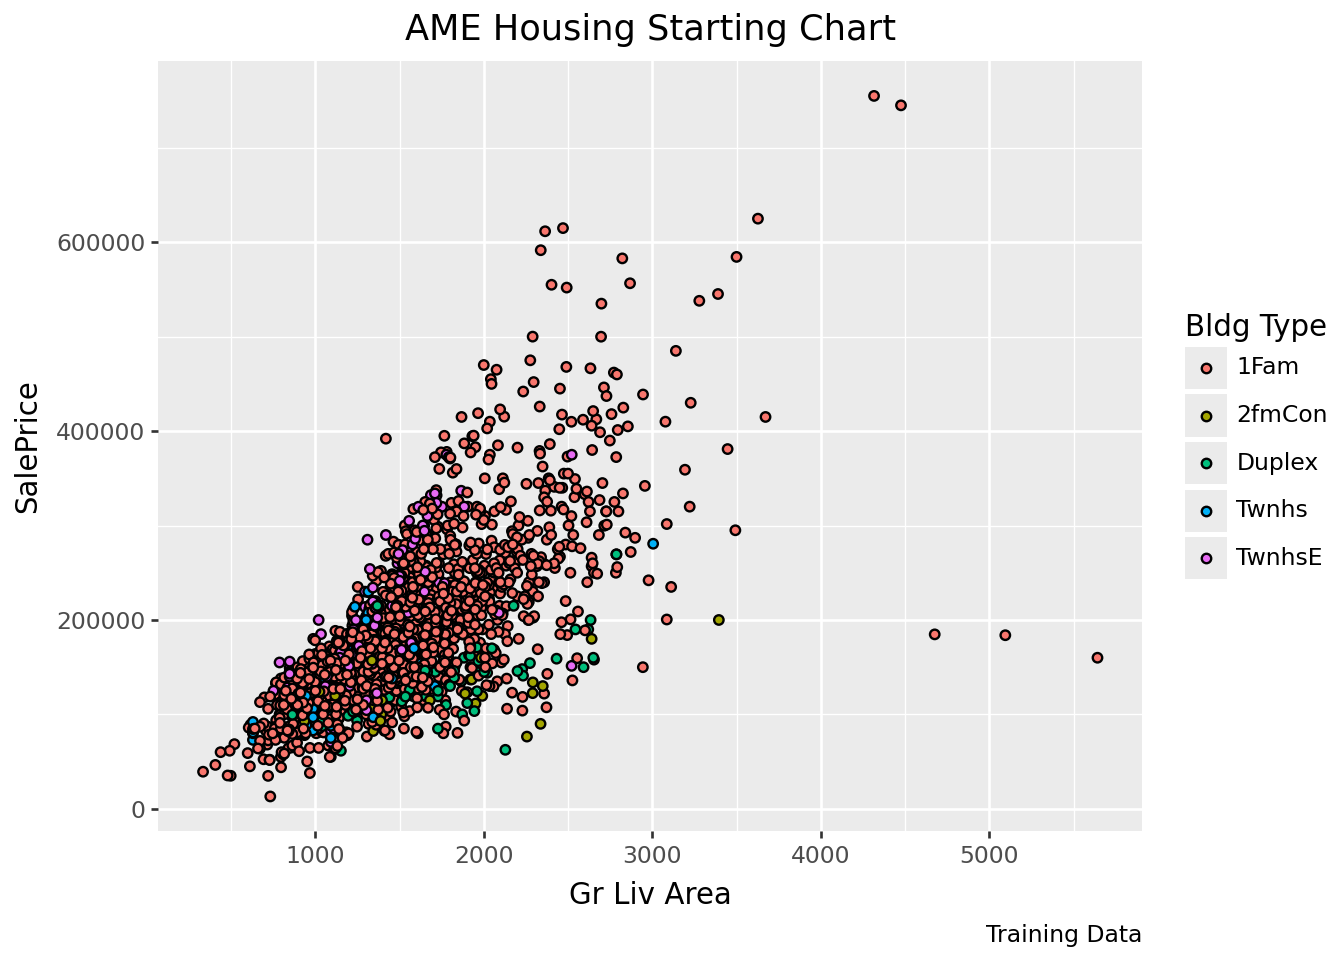

In [4]:
(p9.ggplot(AME_train, p9.aes("Gr Liv Area", "SalePrice", fill = "Bldg Type"))
+p9.labs(title = "AME Housing Starting Chart", caption = "Training Data")
+p9.geom_point())

Looking through the dataset 

In [5]:
AME_train.isna().sum().sort_values(ascending=False)

Lot Frontage     362
Electrical         1
SalePrice          0
Lot Area           0
PID                0
Neighborhood       0
Bldg Type          0
House Style        0
Street             0
Overall Qual       0
Overall Cond       0
Roof Style         0
Year Built         0
Heating            0
Central Air        0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
TotRms AbvGrd      0
Gr Liv Area        0
Functional         0
Screen Porch       0
Pool Area          0
Yr Sold            0
Sale Type          0
dtype: int64

In [6]:
AME_train.corr(numeric_only=True)

,SalePrice,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Full Bath,Half Bath,Bedroom AbvGr,TotRms AbvGrd,Gr Liv Area,Screen Porch,Pool Area,Yr Sold
SalePrice,1.000000,-0.260739,0.361904,0.269321,0.799928,-0.098890,0.559975,0.547815,0.281398,0.144923,0.486375,0.699675,0.119207,0.075599,-0.024833
PID,-0.260739,1.000000,-0.102074,0.034423,-0.275943,0.100645,-0.348374,-0.172124,-0.167059,0.004561,-0.075903,-0.108519,-0.035210,-0.007892,-0.005213
Lot Frontage,0.361904,-0.102074,1.000000,0.481827,0.224628,-0.095110,0.130274,0.189833,0.049522,0.237250,0.361726,0.398677,0.082643,0.198746,-0.005929
Lot Area,0.269321,0.034423,0.481827,1.000000,0.106513,-0.045130,0.024750,0.128633,0.045450,0.138130,0.214742,0.289076,0.066774,0.100217,-0.030312
Overall Qual,0.799928,-0.275943,0.224628,0.106513,1.000000,-0.095948,0.610770,0.527452,0.254225,0.067586,0.374400,0.565505,0.036342,0.034901,-0.009988
Overall Cond,-0.098890,0.100645,-0.095110,-0.045130,-0.095948,1.000000,-0.363320,-0.201791,-0.093456,-0.013158,-0.093924,-0.110786,0.024463,-0.016774,0.045792
Year Built,0.559975,-0.348374,0.130274,0.024750,0.610770,-0.363320,1.000000,0.468460,0.268516,-0.047034,0.119102,0.242299,-0.035189,-0.001036,-0.012550
Full Bath,0.547815,-0.172124,0.189833,0.128633,0.527452,-0.201791,0.468460,1.000000,0.155883,0.361519,0.535858,0.630072,-0.024532,0.026212,-0.006600
Half Bath,0.281398,-0.167059,0.049522,0.045450,0.254225,-0.093456,0.268516,0.155883,1.000000,0.232825,0.336148,0.423292,0.027533,0.007026,-0.001782
Bedroom AbvGr,0.144923,0.004561,0.237250,0.138130,0.067586,-0.013158,-0.047034,0.361519,0.232825,1.000000,0.666348,0.510140,0.007548,0.035886,-0.010757


## Part One: Function and Pipeline Builders

In [7]:
ct = ColumnTransformer(
    [("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output = False)
    , make_column_selector(dtype_exclude=np.number)),  
    ], 
    remainder = "drop" 

).set_output(transform = "pandas" ,)

In [ ]:
def Build_and_Test_Pipeline (pipeline_name,params,
                             model_name, model_sklearn, X, y):

    pipeline_name = Pipeline(
       [("preprocessing", ct),
        (model_name, model_sklearn)]
    )   

    grid = GridSearchCV(pipeline_name, params, cv = 5, scoring = "neg_root_mean_squared_error")
    fit = grid.fit(X, y)
    print(pd.DataFrame(fit.cv_results_)[["params", "mean_test_score"]])
    return (fit.best_params_)




def Final_Fit_and_RSME (pipeline_name, model_name, model_sklearn, X_training,
                         y_training, X_test, y_test, data):
    
    pipeline_name = Pipeline(
     [("preprocessing", ct),
        (model_name, model_sklearn)]
    )

    pipeline_name.fit(X_training, y_training)
    pred = pipeline_name.predict(X_test)
    RSME = np.sqrt(mean_squared_error(y_test, pred))

    data.append({"Model Name" : model_name, 
                        "RMSE" : RSME})
    return(RSME)

## Part Two: Training and Testing Models Using all the data

### 0. X and Y variable Setup

In [9]:
AME_train_d_nan = AME_train.dropna()
AME_train_d_nan = AME_train_d_nan.drop(["PID"], axis = 1)

X1 = AME_train_d_nan.drop(columns=["SalePrice"])
y = AME_train_d_nan["SalePrice"]
y_log = np.log(y)

Part2_results = []

In [10]:
X_train1, X_valid1, y_train_log1, y_valid_log1 = train_test_split(
    X1, y_log, test_size=0.25, random_state=42
)

### 1. Linear Regression

In [11]:
LM_pipe = Pipeline(
       [("preprocessing", ct),
        ("LM", LinearRegression())]
)  

LM_pipe.fit(X_train1, y_train_log1)
LM_pred_valid = LM_pipe.predict(X_valid1)

LM_RMSE1 = np.sqrt(mean_squared_error(y_valid_log1, LM_pred_valid))

Part2_results.append({"Model Name" : "LM", 
                        "RMSE" : LM_RMSE1})

### 2. Ridge Regression

In [12]:
alphas_tune = {"ridge__alpha": [1,2,3,4,5, 6,7]}

Build_and_Test_Pipeline("ridge_pipe", alphas_tune, "ridge", Ridge(), X_train1, y_train_log1)

                params  mean_test_score
0  {'ridge__alpha': 1}        -0.154117
1  {'ridge__alpha': 2}        -0.153798
2  {'ridge__alpha': 3}        -0.153611
3  {'ridge__alpha': 4}        -0.153526
4  {'ridge__alpha': 5}        -0.153505
5  {'ridge__alpha': 6}        -0.153526
6  {'ridge__alpha': 7}        -0.153572


{'ridge__alpha': 5}

In [13]:
Final_Fit_and_RSME("Ridge_Final", "Ridge", Ridge(alpha = 5),
                        X_train1, y_train_log1, X_valid1, y_valid_log1, Part2_results)

np.float64(0.15765395470060234)

### 3. Lasso Regression

In [14]:
alphas_tune2 = {"Lasso__alpha": [0.0001, 0.0002, 0.00025 ,0.0003, 0.0004]}

Build_and_Test_Pipeline("Lasso_model", alphas_tune2,"Lasso", Lasso(), X_train1, y_train_log1)

                      params  mean_test_score
0   {'Lasso__alpha': 0.0001}        -0.153723
1   {'Lasso__alpha': 0.0002}        -0.152946
2  {'Lasso__alpha': 0.00025}        -0.152652
3   {'Lasso__alpha': 0.0003}        -0.152711
4   {'Lasso__alpha': 0.0004}        -0.153011


{'Lasso__alpha': 0.00025}

In [15]:
Final_Fit_and_RSME("Lasso_Final", "Lasso", Lasso(alpha = 0.00025),
                        X_train1, y_train_log1, X_valid1, y_valid_log1, Part2_results)

np.float64(0.15671386629958556)

### 4. Elastic Net Regression

In [16]:
param_grid_EN = {
    "EN__alpha":    [0.0003, 0.0006],
    "EN__l1_ratio": [0.5],
    "EN__max_iter": [2000, 5000, 10000],
}

Build_and_Test_Pipeline("EN_pipe", param_grid_EN, "EN", ElasticNet(), X_train1, y_train_log1)

                                              params  mean_test_score
0  {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.5, 'EN...        -0.153306
1  {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.5, 'EN...        -0.153306
2  {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.5, 'EN...        -0.153306
3  {'EN__alpha': 0.0006, 'EN__l1_ratio': 0.5, 'EN...        -0.152830
4  {'EN__alpha': 0.0006, 'EN__l1_ratio': 0.5, 'EN...        -0.152830
5  {'EN__alpha': 0.0006, 'EN__l1_ratio': 0.5, 'EN...        -0.152830


{'EN__alpha': 0.0006, 'EN__l1_ratio': 0.5, 'EN__max_iter': 2000}

In [17]:
Final_Fit_and_RSME("EN_Final", "EN", ElasticNet(alpha = 0.00025, l1_ratio = 0.5, max_iter=2000),
                        X_train1, y_train_log1, X_valid1, y_valid_log1, Part2_results)

np.float64(0.15645969129628698)

### 5. Tree Regression

In [18]:
param_grid_tree = {
    "tree__max_depth": [None, 3, 5, 8, 12],
    "tree__min_samples_split": [2, 5, 10, 20],
    "tree__min_samples_leaf": [1, 2, 5, 10],
}

Build_and_Test_Pipeline("Tree_pipe", param_grid_tree, "tree", DecisionTreeRegressor(), X_train1, y_train_log1)

                                               params  mean_test_score
0   {'tree__max_depth': None, 'tree__min_samples_l...        -0.223862
1   {'tree__max_depth': None, 'tree__min_samples_l...        -0.219564
2   {'tree__max_depth': None, 'tree__min_samples_l...        -0.211694
3   {'tree__max_depth': None, 'tree__min_samples_l...        -0.203501
4   {'tree__max_depth': None, 'tree__min_samples_l...        -0.215432
..                                                ...              ...
75  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194906
76  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194523
77  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194523
78  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194585
79  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194481

[80 rows x 2 columns]


{'tree__max_depth': 8,
 'tree__min_samples_leaf': 10,
 'tree__min_samples_split': 10}

In [19]:
Final_Fit_and_RSME("Tree_Final", "Tree", DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, min_samples_split=10),
                        X_train1, y_train_log1, X_valid1, y_valid_log1, Part2_results)

np.float64(0.17879203884867234)

### 6. KNN Regression 

In [20]:
param_grid_knn = {
    "KNN__n_neighbors": range(1,10)}

Build_and_Test_Pipeline("KNN_pipe", param_grid_knn, "KNN", KNeighborsRegressor(), X_train1, y_train_log1)

                    params  mean_test_score
0  {'KNN__n_neighbors': 1}        -0.223982
1  {'KNN__n_neighbors': 2}        -0.192932
2  {'KNN__n_neighbors': 3}        -0.186548
3  {'KNN__n_neighbors': 4}        -0.183144
4  {'KNN__n_neighbors': 5}        -0.183418
5  {'KNN__n_neighbors': 6}        -0.182988
6  {'KNN__n_neighbors': 7}        -0.183051
7  {'KNN__n_neighbors': 8}        -0.182634
8  {'KNN__n_neighbors': 9}        -0.183624


{'KNN__n_neighbors': 8}

In [21]:
Final_Fit_and_RSME("Final_KNN", "KNN", KNeighborsRegressor(n_neighbors=8), X_train1, y_train_log1,
                        X_valid1, y_valid_log1, Part2_results)

np.float64(0.16993151495006947)

### 7. Results 

In [22]:
df2 = pd.DataFrame(Part2_results)
df2

,Model Name,RMSE
0,LM,0.157870
1,Ridge,0.157654
2,Lasso,0.156714
3,EN,0.156460
4,Tree,0.178792
5,KNN,0.169932


For this part of Modeling we can see that the Elastic Net model perfromed the best of Regression using our Valid and Training data. Moving to our next models we will be doing this such as interaction varaibles and reducing the amout of x varaibles we work with to try and get better results. 

## Part Three: Reducing the X Varaibles Used 

### 0. Set up

In [23]:
X2 = AME_train_d_nan.drop(["SalePrice", "Street", "House Style", "Overall Cond",
                             "Roof Style", "Yr Sold", "Sale Type"],
                            axis = 1)

Part3_results = []

In [24]:
X_train2, X_valid2, y_train_log2, y_valid_log2 = train_test_split(
    X2, y_log, test_size=0.25, random_state=42
)

### 1. Linear Regression

In [25]:
LM_pipe2 = Pipeline(
       [("preprocessing", ct),
        ("LM", LinearRegression())]
)  

LM_pipe2.fit(X_train2, y_train_log2)
LM_pred_valid2 = LM_pipe2.predict(X_valid2)

LM_RMSE2 = np.sqrt(mean_squared_error(y_valid_log2, LM_pred_valid2))

Part3_results.append({"Model Name" : "LM", 
                        "RMSE" : LM_RMSE2})

### 2. Ridge Regression

In [26]:
param_Ridge_tune = {"ridge__alpha": [1,2,5, 10,20,50]}

Build_and_Test_Pipeline("Ridge_pipe2", param_Ridge_tune, "ridge",Ridge(), X_train2, y_train_log2)

                 params  mean_test_score
0   {'ridge__alpha': 1}        -0.158942
1   {'ridge__alpha': 2}        -0.158914
2   {'ridge__alpha': 5}        -0.159106
3  {'ridge__alpha': 10}        -0.159778
4  {'ridge__alpha': 20}        -0.161056
5  {'ridge__alpha': 50}        -0.163820


{'ridge__alpha': 2}

In [27]:
Final_Fit_and_RSME("Final_Ridge2", "Ridge", Ridge(alpha=2), X_train2, y_train_log2,
                    X_valid2, y_valid_log2, Part3_results)

np.float64(0.16256674492618753)

### 3. Lasso Regression

In [28]:
Param_Lasso_tune = {"Lasso__alpha": [0.00001,0.0001,0.00025, 0.0003]}
Build_and_Test_Pipeline("Lasso_Pipe2", Param_Lasso_tune, "Lasso", Lasso(), X_train2, y_train_log2)

                      params  mean_test_score
0    {'Lasso__alpha': 1e-05}        -0.159133
1   {'Lasso__alpha': 0.0001}        -0.158540
2  {'Lasso__alpha': 0.00025}        -0.158226
3   {'Lasso__alpha': 0.0003}        -0.158413


{'Lasso__alpha': 0.00025}

In [29]:
Final_Fit_and_RSME("Final_Lasso2", "Lasso", Lasso(alpha = 0.00025), X_train2, y_train_log2,
                    X_valid2, y_valid_log2, Part3_results)

np.float64(0.1639818807913965)

### 4. Elastic Net Regression

In [30]:
param_grid_EN2 = {
    "EN__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],   # strength of regularization
    "EN__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],           # 0 = ridge, 1 = lasso
    "EN__max_iter": [1000, 5000, 10000],                 # allow convergence
}

Build_and_Test_Pipeline("EN_Pipe", param_grid_EN2, "EN", ElasticNet(), X_train2, y_train_log2)

                                               params  mean_test_score
0   {'EN__alpha': 0.0001, 'EN__l1_ratio': 0.1, 'EN...        -0.159010
1   {'EN__alpha': 0.0001, 'EN__l1_ratio': 0.1, 'EN...        -0.159010
2   {'EN__alpha': 0.0001, 'EN__l1_ratio': 0.1, 'EN...        -0.159010
3   {'EN__alpha': 0.0001, 'EN__l1_ratio': 0.3, 'EN...        -0.158905
4   {'EN__alpha': 0.0001, 'EN__l1_ratio': 0.3, 'EN...        -0.158905
..                                                ...              ...
85  {'EN__alpha': 10.0, 'EN__l1_ratio': 0.7, 'EN__...        -0.427920
86  {'EN__alpha': 10.0, 'EN__l1_ratio': 0.7, 'EN__...        -0.427920
87  {'EN__alpha': 10.0, 'EN__l1_ratio': 0.9, 'EN__...        -0.427920
88  {'EN__alpha': 10.0, 'EN__l1_ratio': 0.9, 'EN__...        -0.427920
89  {'EN__alpha': 10.0, 'EN__l1_ratio': 0.9, 'EN__...        -0.427920

[90 rows x 2 columns]


{'EN__alpha': 0.0001, 'EN__l1_ratio': 0.9, 'EN__max_iter': 1000}

In [31]:
Final_Fit_and_RSME("EN_Pipe2", "EN", ElasticNet(alpha = 0.0001, l1_ratio= 0.9, max_iter=1000), 
                    X_train2, y_train_log2, X_valid2, y_valid_log2, Part3_results)

np.float64(0.1620343188030908)

### 5. Tree Regression

In [32]:
param_grid_tree2 = {
    "tree__max_depth": [None, 3, 5, 8, 12],
    "tree__min_samples_split": [2, 5, 10, 20],
    "tree__min_samples_leaf": [1, 2, 5, 10],
}

Build_and_Test_Pipeline("Tree_pipe2", param_grid_tree2, "tree", DecisionTreeRegressor(),
                         X_train2, y_train_log2)

                                               params  mean_test_score
0   {'tree__max_depth': None, 'tree__min_samples_l...        -0.222379
1   {'tree__max_depth': None, 'tree__min_samples_l...        -0.214263
2   {'tree__max_depth': None, 'tree__min_samples_l...        -0.211419
3   {'tree__max_depth': None, 'tree__min_samples_l...        -0.204940
4   {'tree__max_depth': None, 'tree__min_samples_l...        -0.208866
..                                                ...              ...
75  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194498
76  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194896
77  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194896
78  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194896
79  {'tree__max_depth': 12, 'tree__min_samples_lea...        -0.194896

[80 rows x 2 columns]


{'tree__max_depth': 8,
 'tree__min_samples_leaf': 10,
 'tree__min_samples_split': 10}

In [33]:
Final_Fit_and_RSME("Tree_Final2", "Tree", DecisionTreeRegressor(max_depth = 8, min_samples_leaf =10, min_samples_split = 5 ),
                    X_train2, y_train_log2, X_valid2, y_valid_log2, Part3_results)

np.float64(0.17891687691421154)

### 6. KNN Regression

In [34]:
param_grid_knn2 = {
    "KNN__n_neighbors": [5,10,12,15,20,50]}

Build_and_Test_Pipeline("KNN_pipe2", param_grid_knn2, "KNN", KNeighborsRegressor(), X_train2, y_train_log2)

                     params  mean_test_score
0   {'KNN__n_neighbors': 5}        -0.183187
1  {'KNN__n_neighbors': 10}        -0.181662
2  {'KNN__n_neighbors': 12}        -0.184439
3  {'KNN__n_neighbors': 15}        -0.186697
4  {'KNN__n_neighbors': 20}        -0.188661
5  {'KNN__n_neighbors': 50}        -0.205859


{'KNN__n_neighbors': 10}

In [35]:
Final_Fit_and_RSME("KNN_Pipe2", "KNN", KNeighborsRegressor(n_neighbors=10), 
                    X_train2, y_train_log2, X_valid2, y_valid_log2, Part3_results)

np.float64(0.16838266878458932)

### 7. Results 

In [36]:
df3 = pd.DataFrame(Part3_results)
df3

,Model Name,RMSE
0,LM,0.161203
1,Ridge,0.162567
2,Lasso,0.163982
3,EN,0.162034
4,Tree,0.178917
5,KNN,0.168383


## Part Four: Polynomial Regression

### 0. Set Up

In [37]:
# Selectors (you can also pass explicit lists of column names)
numeric_features = make_column_selector(dtype_include=["int64", "float64"])
categorical_features = make_column_selector(dtype_include=["object", "category"])

# Pipeline just for numeric part: scale -> poly
num_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))  # degree=2 to start
])

# ColumnTransformer: numeric gets num_poly, categoricals get one-hot
ct_poly = ColumnTransformer(
    transformers=[
        ("num", num_poly, numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

### 1. Poly Pipeline

In [38]:
PolyLM_pipe = Pipeline(
    [
        ("preprocessing", ct_poly),
        ("LM", LinearRegression())
    ]
)

param_grid_poly = {
    "preprocessing__num__poly__degree": [1, 2, 3,4,5],  # 1 = plain linear
}

grid_poly = GridSearchCV(
    PolyLM_pipe,
    param_grid=param_grid_poly,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

grid_poly.fit(X_train1, y_train_log1)
print("Best params:", grid_poly.best_params_)
print("Best log-RMSE:", -grid_poly.best_score_)

Best params: {'preprocessing__num__poly__degree': 1}
Best log-RMSE: 0.15469805431180889


In [39]:
best_poly = grid_poly.best_estimator_

In [40]:
poly_pred_valid = best_poly.predict(X_valid1)
poly_RMSE = np.sqrt(mean_squared_error(y_valid_log1, poly_pred_valid))

In [41]:
part4_data = []

part4_data.append({"Model Name" : "Poly", 
                        "RMSE" : poly_RMSE})
df4 = pd.DataFrame(part4_data)
df4

,Model Name,RMSE
0,Poly,0.157872


## Part Five: Interaction Terms 

### 0. Set Up

In [42]:
num_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("interact", PolynomialFeatures(
        degree=2,
        interaction_only=True,
        include_bias=False
    )),
])

ct_interact = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

In [43]:
def Build_and_Test_inter_pipe (pipeline_name,params,
                             model_name, model_sklearn, X, y):

    pipeline_name = Pipeline(
       [("preprocessing", ct_interact),
        (model_name, model_sklearn)]
    )   

    grid = GridSearchCV(pipeline_name, params, cv = 5, scoring = "neg_root_mean_squared_error")
    fit = grid.fit(X, y)
    print(pd.DataFrame(fit.cv_results_)[["params", "mean_test_score"]])
    return (fit.best_params_)




def Final_Fit_Inter_and_RSME (pipeline_name, model_name, model_sklearn, X_training,
                         y_training, X_test, y_test, data):
    
    pipeline_name = Pipeline(
     [("preprocessing", ct_interact),
        (model_name, model_sklearn)]
    )

    pipeline_name.fit(X_training, y_training)
    pred = pipeline_name.predict(X_test)
    RSME = np.sqrt(mean_squared_error(y_test, pred))

    data.append({"Model Name" : model_name, 
                        "RMSE" : RSME})
    return(RSME)

In [44]:
Part5_Results = []

### 1. Linear Model

In [45]:
LM_Inter_Pipe = Pipeline(
    [("preprocessing", ct_interact), 
     ("LM", LinearRegression())]
)

LM_Inter_Pipe.fit(X_train1, y_train_log1)
LM_Inter_pred_valid = LM_Inter_Pipe.predict(X_valid1)

LM_Inter_RMSE = np.sqrt(mean_squared_error(y_valid_log1, LM_Inter_pred_valid))

Part5_Results.append({"Model Name" : "LM", 
                        "RMSE" : LM_Inter_RMSE})

### 2. Elastic Net

In [46]:
param_Inter_EN = {
    "EN__alpha":    [0.0003, 0.00045, 0.0006, 0.0008, 0.001],
    "EN__l1_ratio": [ 0.5, 0.6, 0.7,0.8,0.9],
    "EN__max_iter": [5000, 10000],   
}

In [47]:
Build_and_Test_inter_pipe("EN_Inter_Pipe", param_Inter_EN, "EN", ElasticNet(), X_train1, y_train_log1)

                                               params  mean_test_score
0   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.5, 'EN...        -0.148484
1   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.5, 'EN...        -0.148484
2   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.6, 'EN...        -0.148081
3   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.6, 'EN...        -0.148081
4   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.7, 'EN...        -0.147770
5   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.7, 'EN...        -0.147770
6   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.8, 'EN...        -0.147531
7   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.8, 'EN...        -0.147531
8   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.9, 'EN...        -0.147416
9   {'EN__alpha': 0.0003, 'EN__l1_ratio': 0.9, 'EN...        -0.147416
10  {'EN__alpha': 0.00045, 'EN__l1_ratio': 0.5, 'E...        -0.147772
11  {'EN__alpha': 0.00045, 'EN__l1_ratio': 0.5, 'E...        -0.147772
12  {'EN__alpha': 0.00045, 'EN__l1_ratio': 0.6, 'E...        -0.147543
13  {'

{'EN__alpha': 0.00045, 'EN__l1_ratio': 0.9, 'EN__max_iter': 5000}

In [48]:
Final_Fit_Inter_and_RSME("EN_Inter_Final", "EN", ElasticNet(alpha = 0.00045, l1_ratio = 0.9, max_iter=5000),
                        X_train1, y_train_log1, X_valid1, y_valid_log1, Part5_Results)

np.float64(0.12966420741338197)

### 3. Results 

In [49]:
df5 = pd.DataFrame(Part5_Results)
df5

,Model Name,RMSE
0,LM,0.137715
1,EN,0.129664


## Part Six: Interpreting the Results 

In [50]:
AllData = df2[["Model Name", "RMSE"]].copy()
AllData["Data_Type"] = "All"

Selected = df3[["Model Name", "RMSE"]].copy()
Selected["Data_Type"] = "Select"

Poly = df4[["Model Name", "RMSE"]].copy()
Poly["Data_Type"] = "Poly"

Inter = df5[["Model Name", "RMSE"]].copy()
Inter["Data_Type"] = "Inter"

In [51]:
Regression_Models_Scores = pd.concat([AllData, Selected, Poly, Inter], ignore_index= True)

Regression_Models_Scores

,Model Name,RMSE,Data_Type
0,LM,0.157870,All
1,Ridge,0.157654,All
2,Lasso,0.156714,All
3,EN,0.156460,All
4,Tree,0.178792,All
5,KNN,0.169932,All
6,LM,0.161203,Select
7,Ridge,0.162567,Select
8,Lasso,0.163982,Select
9,EN,0.162034,Select


Looking at the Table Above we can see that the EN Interaction Model Performed the best with a predicted valid RMSE of .1296, This value is just an estimate as we have no way in knowing until we interpret on the true data but this give us a sold understanding of how our models performed

## Part Seven: Prediction Extraction

In [52]:
X_test = AME_test.drop("PID", axis = 1)

In [53]:
Final_Pipeline = Pipeline(
    [("Preprocessing", ct_interact), 
     ("EN", ElasticNet(alpha = 0.00045, l1_ratio = 0.9, max_iter=5000))
     ]
    )

Final_Pipeline.fit(X_train1, y_train_log1)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('interact',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001ACC5FE1D90>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001ACC5FE0E90>)])),
                ('EN', ElasticNet(alpha=0.00045, l1_ratio=0.9, max_iter=5000))])

In [54]:
test_pred_log = Final_Pipeline.predict(X_test)

In [55]:
test_pred = np.exp(test_pred_log)

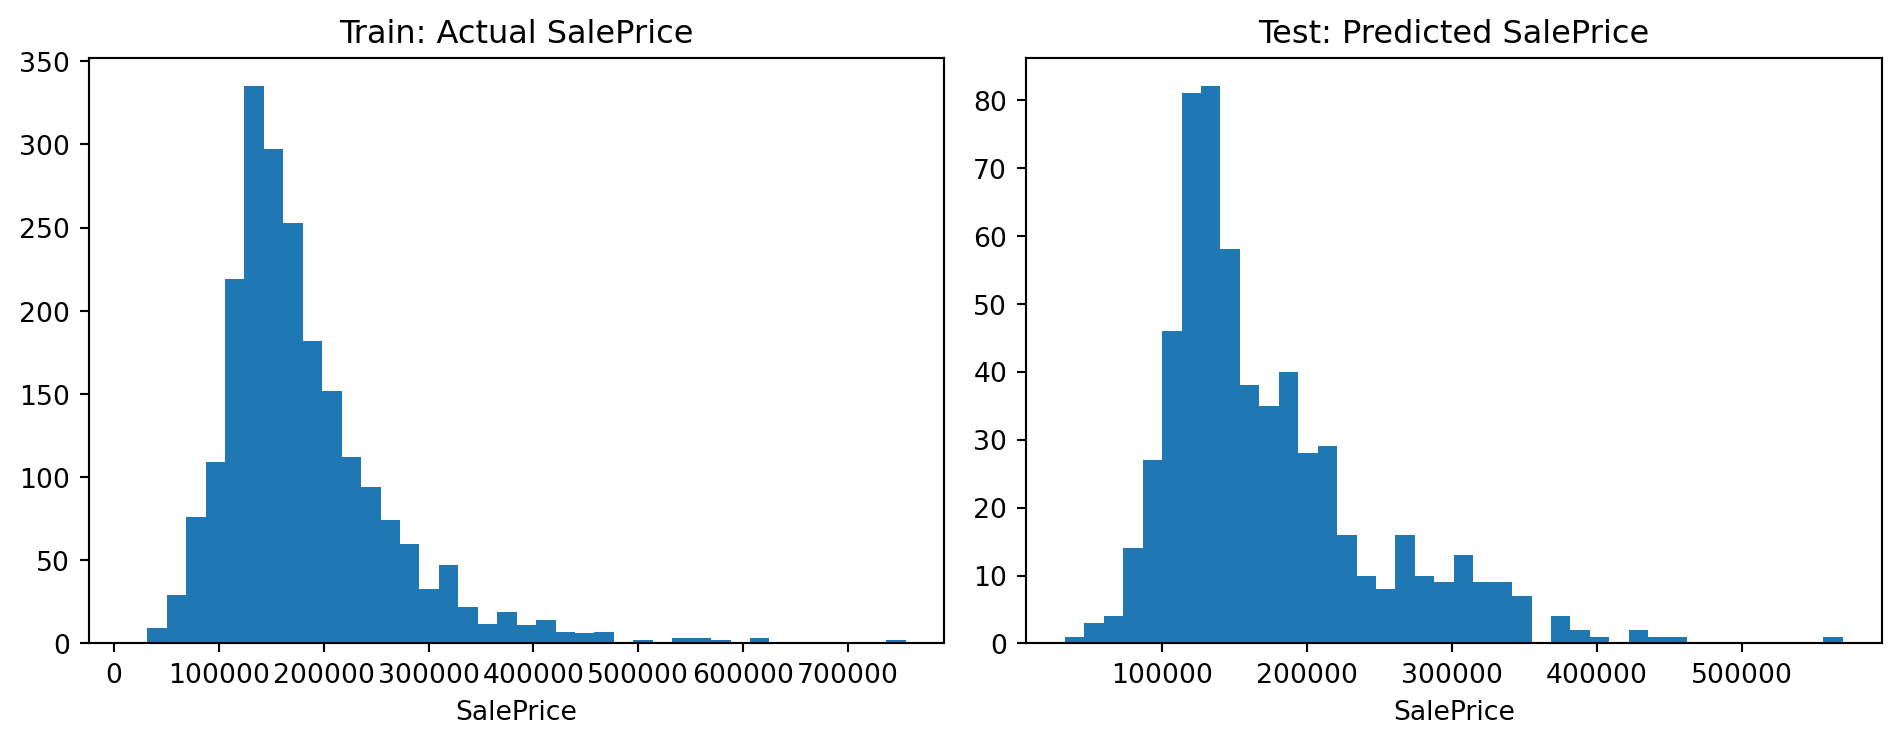

In [56]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(AME_train["SalePrice"], bins=40)
plt.title("Train: Actual SalePrice")
plt.xlabel("SalePrice")

plt.subplot(1, 2, 2)
plt.hist(test_pred, bins=40)
plt.title("Test: Predicted SalePrice")
plt.xlabel("SalePrice")

plt.tight_layout()
plt.show()

In [57]:
submission = pd.DataFrame({
    "PID": AME_test["PID"].values, 
    "SalePrice": test_pred
})

submission.to_csv("Lucas_Submission_1.csv", index = False)